### Лабораторная работа №1
Кудряшов Александр, группа с4110

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing

import random

In [2]:
cancer = datasets.load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['target'] = cancer['target']

Теперь тут по-хорошему надо изучить все тридцать признаков по отдельности, очистить от выбросов, выбрать правильный способ нормализации данных для каждого признака. Но сделать это ой как не просто, учитывая сложную природу данных, которую я не знаю. Поэтому просто применяем StandartScaler() 

In [150]:
X_, y = df.drop(['target'], axis=1), df['target']
sum(y)/len(y)

0.62741652021089633

In [4]:
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_), columns=cancer['feature_names'])

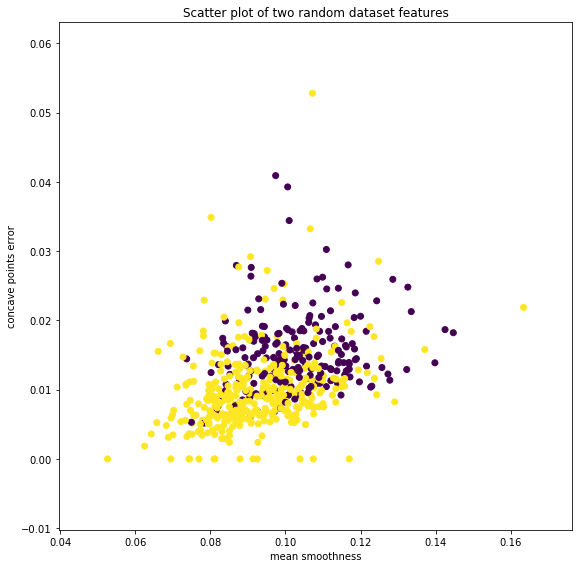

In [74]:
keys = df.keys().tolist()
np.random.shuffle(keys)
plt.figure(figsize=(8, 8))
plt.scatter(df[keys[0]], df[keys[1]], c=df['target'])
plt.title('Scatter plot of two random dataset features')
plt.xlabel(keys[0])
plt.tight_layout()
plt.ylabel(keys[1]);

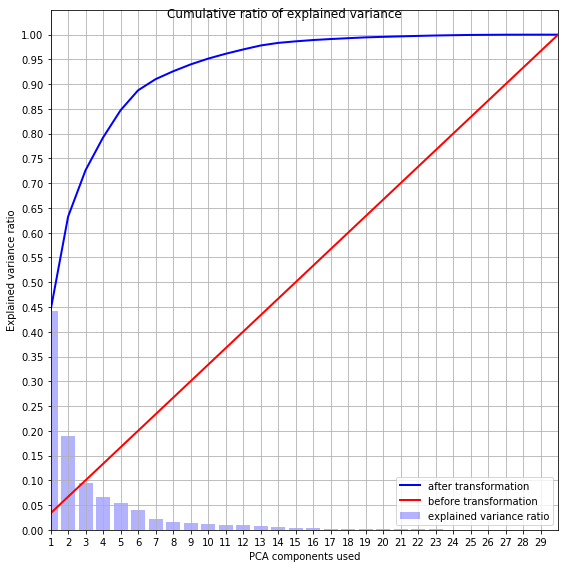

In [180]:
pca = PCA()
pca.fit(X)
plt.figure(figsize=(8, 8))
plt.plot(range(1, 31), pca.explained_variance_ratio_.cumsum(), linewidth=2, color='b',
         linestyle = '-', label='after transformation')
plt.plot(range(1, 31), (X.var().sort_values(ascending=False)/sum(X.var())).cumsum(),
         linewidth=2, color='r', label='before transformation')
plt.bar(range(1, 31), pca.explained_variance_ratio_,color='b', alpha=0.3, label='explained variance ratio')
plt.xlabel('PCA components used')
plt.ylabel('Explained variance ratio')
plt.suptitle('Cumulative ratio of explained variance')
plt.xticks(range(30))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xlim(1, 30)
plt.grid()
plt.tight_layout()
plt.legend();

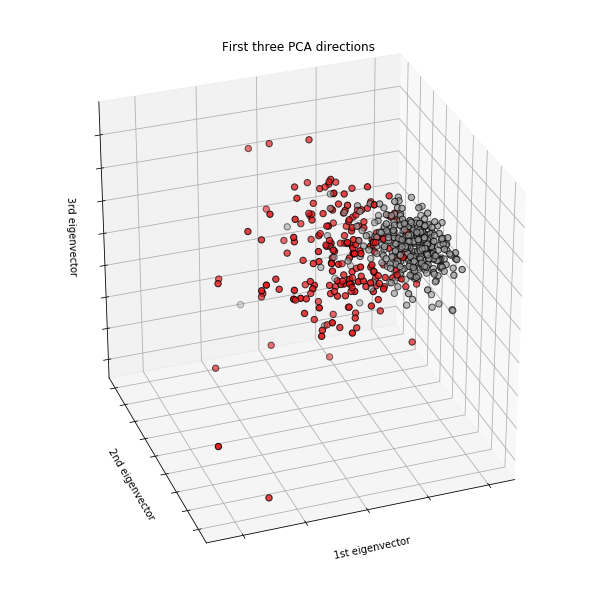

In [209]:
# возьмем десять первых компонент
# как видно из графика, это покроет чуть больше 95% дисперсии
N = 10
pca = PCA(n_components=N)
X_transformed = pca.fit_transform(X)
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y,
            cmap=plt.cm.Set1, edgecolor='k', s=40, label=y)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([]);

In [210]:
cov_matrix = np.cov(X.T, bias=False) # матрица ковариации до преобразования

In [211]:
assert all(np.isclose(0, np.dot(*X_transformed.T[i:i+2])) for i in range(N-1)), 'Увы, но компоненты не ортогональны'

In [212]:
# собственные значения матрицы ковариации должны совпадать со значениями дисперсии главных компонент
eigvals = np.linalg.eigvals(cov_matrix)
assert all(map(lambda x:np.isclose(x[0], x[1]), zip(eigvals, pca.explained_variance_))), 'Ох, они не совпадают'

In [213]:
transformed_cov_matrix = np.cov(X_transformed.T, bias=False)

In [214]:
# проверяем, что след матрицы ковариации не изменился после трансформации
assert np.isclose(np.trace(cov_matrix), np.trace(transformed_cov_matrix)), 'Увы, но след матрицы почему-то изменился'

AssertionError: Увы, но след матрицы почему-то изменился

In [215]:
# на самом деле в этом нет ничего удивительного, ведь мы "берем с собой" только примерно 95% объясненной диисперсии
# и как раз столько получается, если разделить одно значение на другое
np.trace(transformed_cov_matrix)/np.trace(cov_matrix)

0.95156881433435503

In [216]:
# убедимся, что они точно совпадают
# для этого сделаем pca декомпозицию еще раз, на этот раз уже для всех векторов
assert np.isclose(np.cov(PCA().fit_transform(X).T).trace(), cov_matrix.trace()), 'И в этот раз не получилось :('

In [372]:
# просто и в упор посчитаем метрики для KNC на случайном количестве соседей
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1)
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test), target_names=['no cancer', 'cancer'], digits=5))
# https://en.wikipedia.org/wiki/Precision_and_recall

             precision    recall  f1-score   support

  no cancer    1.00000   0.96000   0.97959        25
     cancer    0.96970   1.00000   0.98462        32

avg / total    0.98299   0.98246   0.98241        57



In [373]:
# теперь сделаем то же самое,  но с перекрестной проверкой
predicted = cross_val_predict(classifier, X, y, cv=10)
print(classification_report(y, predicted, target_names=['no cancer', 'cancer'], digits=5))

             precision    recall  f1-score   support

  no cancer    0.98969   0.90566   0.94581       212
     cancer    0.94667   0.99440   0.96995       357

avg / total    0.96270   0.96134   0.96095       569



In [374]:
# оценим дисперсию
accuracy = cross_val_score(classifier, X, y, cv=10, scoring='recall')
print(accuracy)
accuracy.var()

[ 0.97222222  1.          0.97222222  1.          1.          1.          1.
  1.          1.          1.        ]


0.00012345679012345693

In [375]:
# построим теперь графики зависимости метрик от числа соседей в KNC
def get_scores(X, y, clf, cv=10):
    mtrcs = metrics.f1_score, metrics.accuracy_score, metrics.precision_score, metrics.recall_score
    mtrcs_strings = ['f1','accuracy', 'precision', 'recall']
    scores_ = [[cross_val_score(clf, X, y, scoring=metrics.make_scorer(m), cv=cv)] for m in mtrcs]
    scores = [ [ms, np.array(s).mean(), np.array(s).var()] for s,ms in zip(scores_, mtrcs_strings)]
    return scores

In [376]:
results_df = pd.DataFrame(columns=['n', 'k', 'metrics', 'mean', 'variance'])
i = 0
for k in range(2, 100, 5):
    for n in [2, 5, 8, 10]:
        clf = KNeighborsClassifier(n_neighbors=k)
        scrs = get_scores(X, y, clf, cv=n)
        for scr in scrs:
            results_df.loc[i,:]=[n, k, scr[0], scr[1], scr[2]]
            i += 1

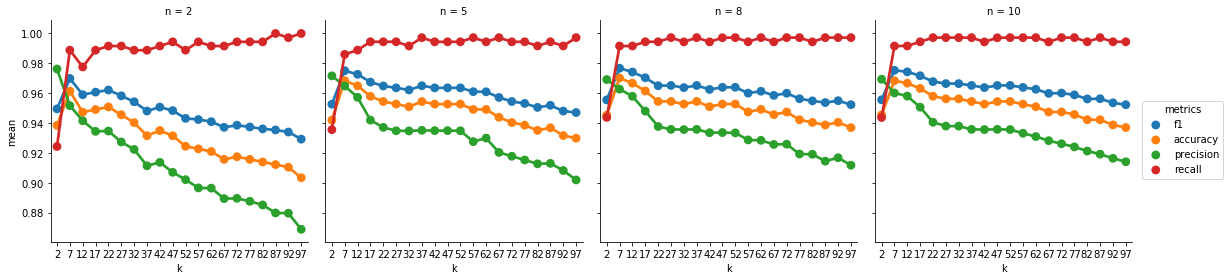

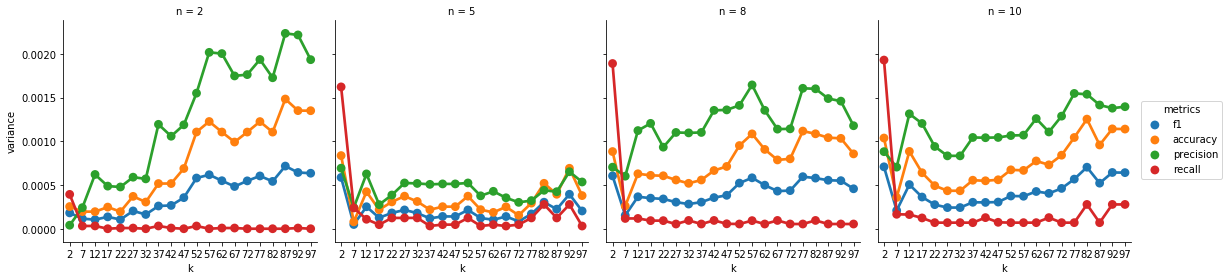

In [377]:
sns.factorplot(x='k', 
             y='mean', 
             data=results_df, 
             hue='metrics',  
             col='n')
sns.factorplot(x='k', 
             y='variance', 
             data=results_df, 
             hue='metrics',  
             col='n');

### По графикам выше отлично видно, что лучший диапазон значений -- где-то от 3 и до 20, если грубо
Ведь самая важная для нас метрика -- recall, т.к. мы имеем дело с раком груди, и важно не пропустить подозрительные случаи.
При этом отлично видно, что эта метрика стабильно высока при k большем примерно пяти, в то время как другие метрики с увеличением k снижаются, а их разброс растет

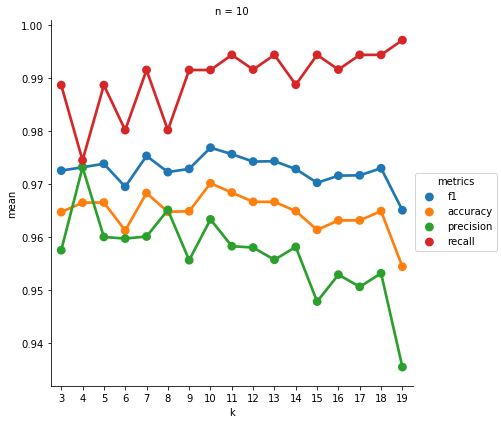

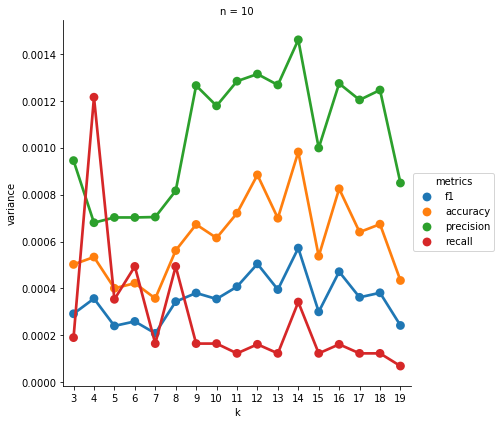

In [378]:
# построим график для найденного выше диапазона
results_df = pd.DataFrame(columns=['n', 'k', 'metrics', 'mean', 'variance'])
i = 0
for k in range(3, 20):
        clf = KNeighborsClassifier(n_neighbors=k)
        scrs = get_scores(X, y, clf, cv=10)
        for scr in scrs:
            results_df.loc[i,:]=[10, k, scr[0], scr[1], scr[2]]
            i += 1


sns.factorplot(x='k', 
             y='mean', 
             data=results_df, 
             hue='metrics',  
             col='n', size = 6)
sns.factorplot(x='k', 
             y='variance', 
             data=results_df, 
             hue='metrics',  
             col='n', size = 6);


### Зафиксируем оптимальное число соседей -- 7-11
### И  выведем для него значения метрик как некий эталон, на который надо ровняться

In [391]:
best_neightbors = set(range(7, 12))
best_metrics_values = results_df[results_df['k'].isin(best_neightbors)]
best_metrics_values

,n,k,metrics,mean,variance
16,10,7,f1,0.975368,0.000208749
17,10,7,accuracy,0.968355,0.000357587
18,10,7,precision,0.960144,0.000704493
19,10,7,recall,0.991587,0.00016518
20,10,8,f1,0.972308,0.000343964
21,10,8,accuracy,0.964815,0.000561886
22,10,8,precision,0.965159,0.000816362
23,10,8,recall,0.980238,0.00049401
24,10,9,f1,0.972915,0.000380818
25,10,9,accuracy,0.964908,0.000672961


In [398]:
# проделаем теперь то же самое для X_transformed
results_df_transformed = pd.DataFrame(columns=['n_pca', 'k', 'metrics', 'mean', 'variance'])
i = 0
for k in best_neightbors:
    for n in range(7, 30, 6):
        pca = PCA(n_components=n)
        pca.fit(X)
        X_ = pca.transform(X)
        clf = KNeighborsClassifier(n_neighbors=k)
        scrs = get_scores(X_, y, clf, cv=10)
        for scr in scrs:
            results_df_transformed.loc[i,:]=[n, k, scr[0], scr[1], scr[2]]
            i += 1

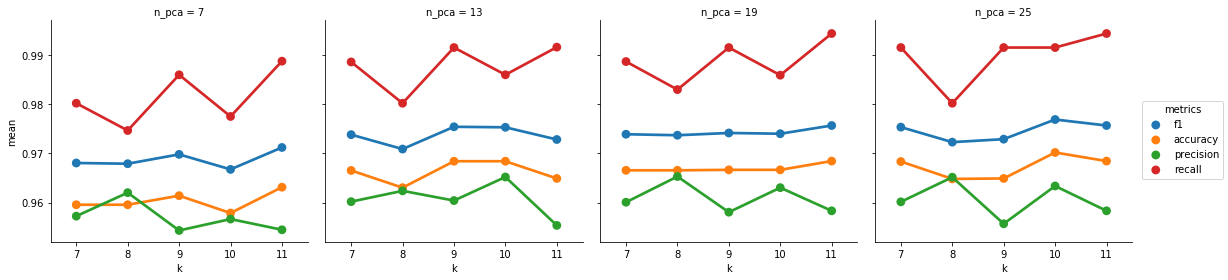

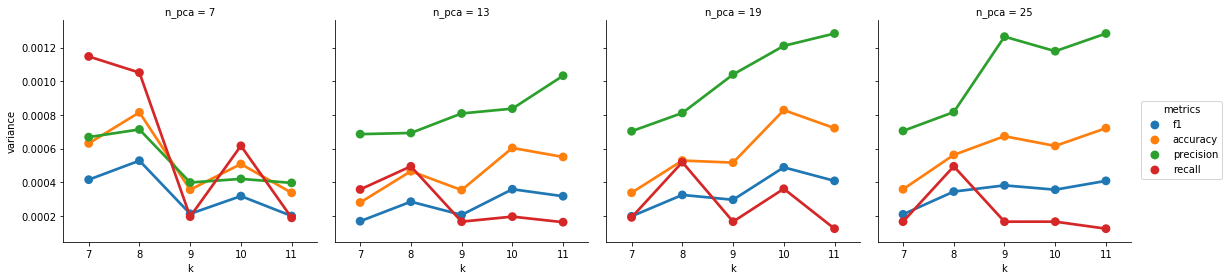

In [394]:
sns.factorplot(x='k', 
             y='mean', 
             data=results_df_transformed, 
             hue='metrics',  
             col='n_pca')
sns.factorplot(x='k', 
             y='variance', 
             data=results_df_transformed, 
             hue='metrics',  
             col='n_pca');

In [401]:
%%time
clf1 = KNeighborsClassifier(n_neighbors=10)
r1 = get_scores(X, y, clf1, cv=10)

Wall time: 318 ms


In [396]:
%%time
clf2 = KNeighborsClassifier(n_neighbors=10)
r2 = get_scores(X_transformed, y, clf2, cv=10)

Wall time: 186 ms


In [399]:
print('metrics', 'mean diff', 'variance diff', sep='\t')
for t1, t2 in zip(r1, r2):
    print(t1[0], t1[1] - t2[1], t1[2] - t2[2], sep='\t')

metrics	mean diff	variance diff
f1	0.00295861297897	5.19284276216e-05
accuracy	0.00350985221675	0.000104630523209
precision	0.000747589694958	0.000350779713219
recall	0.00555555555556	-2.99823633157e-05


# Вывод
### Метод главный компонент -- рабочий инструмент. Даже на таком небольшом наборе данных он дал выигрыш по времени в два раза, при этом мы потеряли в каждой из различных оценок точности что-то около третьего знака после запятой, т.е. меньше половины процента.